In [1]:
import platform, sys, os, shutil
import packaging.version as pv
import time

try:
    from google.colab import files
    from google.colab import drive
    drive.mount('/content/drive/')
    print('Google Colab environment detected. Mounted Google Drive.')
except ImportError:
    print('This is not Google Colab.')

python_version=platform.python_version()
print('Python version:', python_version)

if pv.parse(python_version) < pv.parse("3.0.0"):
    print("Python3 is needed!")
    print("How to fix: Runtime/Change_runtime_type/Python 3")
    sys.exit()

try:
    from dolfin import *
    from dolfin import __version__ as dolfin_version
    import mshr
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import __version__ as mpl_version
    import pandas as pd
    from tqdm import tqdm
    import scipy.optimize as opt
    from scipy.stats import norm as sp_norm
    from scipy.integrate import quad
    from scipy.integrate import simpson
    from scipy.signal import find_peaks
    from scipy import __version__ as sp_version
    from scipy.optimize import fsolve
    import mpmath
    import openturns as ot
    from sklearn.neighbors import KernelDensity
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    from tabulate import tabulate
    import plotly.graph_objs as go
    import plotly.io as pio
    from datetime import datetime
    import re
    import csv
except ImportError as e:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *
    from dolfin import __version__ as dolfin_version
    import mshr
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import __version__ as mpl_version
    import pandas as pd
    from tqdm import tqdm
    import scipy.optimize as opt
    from scipy.stats import norm as sp_norm
    from scipy.integrate import quad
    from scipy.integrate import simpson
    from scipy.signal import find_peaks
    from scipy.optimize import fsolve
    from scipy import __version__ as sp_version
    import mpmath
    !pip install openturns
    import openturns as ot
    !pip install scikit-learn
    from sklearn.neighbors import KernelDensity
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    from tabulate import tabulate
    !pip install plotly
    !pip install kaleido
    import plotly.graph_objs as go
    import plotly.io as pio
    from datetime import datetime
    import re
    import csv

try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rc('lines', linewidth=3)

from IPython.display import clear_output, display

import warnings
warnings.filterwarnings("ignore")

ot.Log.Show(ot.Log.NONE)

set_log_level(30)

parameters['allow_extrapolation'] = True
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 3
parameters['form_compiler']['representation'] = 'uflacs'
parameters['linear_algebra_backend'] = "PETSc"

print('numpy version:', np.__version__)
print('scipy version:', sp_version)
print('matplotlib version:', mpl_version)
print('dolfin version:', dolfin_version)
print('gmsh version:', gmsh.__version__)
print('mpmath version:', mpmath.__version__)

try:
    from ILT import *
    from Functions_NMR import *
    from FEM_NMR import *
    from SemiA_Sphere_NMR import *
    from Conv_NMR import *
    from ND_FEM_NMR import *
except ImportError:
    !wget 'https://raw.githubusercontent.com/smoralesc91/NMR_FEM/main/Codes/ILT.py'
    !wget 'https://raw.githubusercontent.com/smoralesc91/NMR_FEM/main/Codes/Functions_NMR.py'
    !wget 'https://raw.githubusercontent.com/smoralesc91/NMR_FEM/main/Codes/FEM_NMR.py'
    !wget 'https://raw.githubusercontent.com/smoralesc91/NMR_FEM/main/Codes/SemiA_Sphere_NMR.py'
    !wget 'https://raw.githubusercontent.com/smoralesc91/NMR_FEM/main/Codes/Conv_NMR.py'
    !wget 'https://raw.githubusercontent.com/smoralesc91/NMR_FEM/main/Codes/ND_FEM_NMR.py'
    from ILT import *
    from Functions_NMR import *
    from FEM_NMR import *
    from SemiA_Sphere_NMR import *
    from Conv_NMR import *
    from ND_FEM_NMR import *

print('ILT version:', ilt.__version__)
print('Functions_NMR version:', NMR_Functions.__version__)
print('FEM_NMR version:', NMR_FEM.__version__)
print('SemiA_Sphere_NMR version:', NMR_SemiA_sphere.__version__)
print('Conv_NMR version:', NMR_Conventional.__version__)
print('ND_FEM_NMR version:', ND_BT_FEM.__version__)

This is not Google Colab.
Python version: 3.12.3
numpy version: 1.26.4
scipy version: 1.11.4
matplotlib version: 3.6.3
dolfin version: 2019.2.0.64.dev0
gmsh version: 4.13.1
mpmath version: 1.2.1
ILT version: 1.0
Functions_NMR version: 1.0
FEM_NMR version: 1.5-spatial-profile
SemiA_Sphere_NMR version: 1.7-spatial-profile
Conv_NMR version: 1.0
ND_FEM_NMR version: 0.4_Rigorous_Analytic


# Testing

## Numerical

FEM Solver: 100%|████████████████████████| 1000/1000 [00:03<00:00, 317.67step/s]


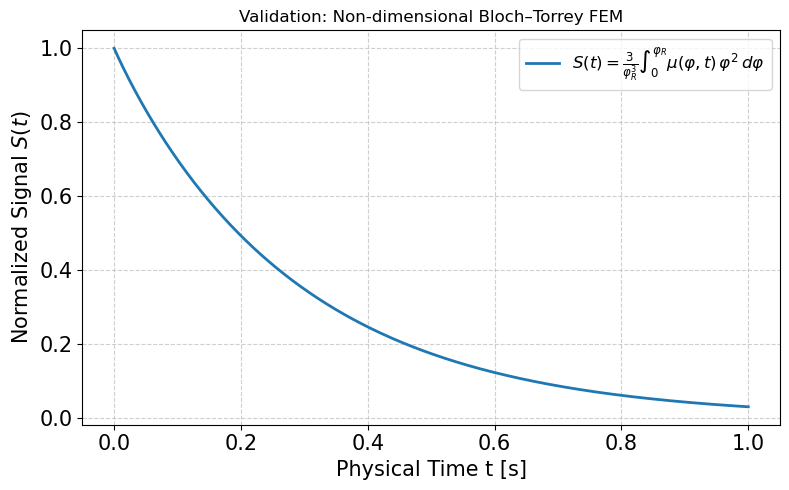

Exported 21 snapshots to /snaps_nd_csv


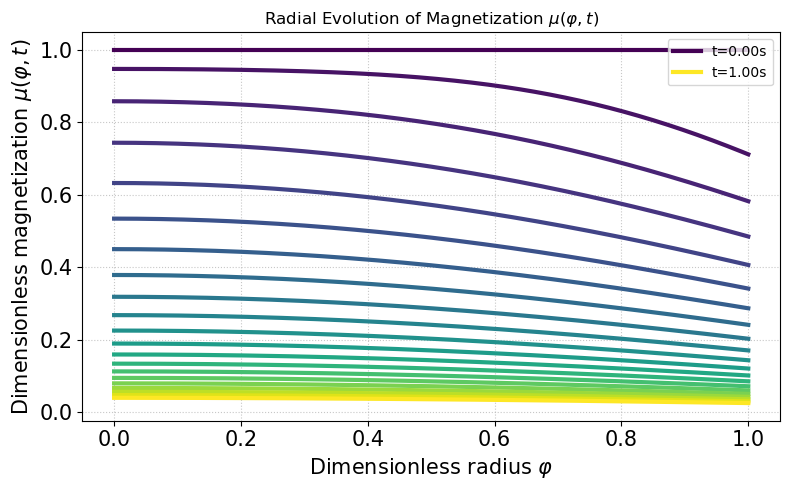

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from dolfin import *

# Asegúrate de que la función ND_BT_FEM esté cargada o importada aquí
# from tu_modulo import ND_BT_FEM 

# ---- Helper Function (Necesaria para extraer datos de FEniCS) ----
def get_1d_profile(func):
    """
    Extracts coordinate (phi) and field (mu) arrays from a 1D FEniCS Function.
    Orders them by coordinate value.
    """
    mesh = func.function_space().mesh()
    # Get coordinates
    coords = mesh.coordinates().flatten()
    # Get values at vertices
    vals = func.compute_vertex_values(mesh)
    
    # Sort by coordinate (FEniCS doesn't guarantee order)
    sorted_indices = np.argsort(coords)
    return coords[sorted_indices], vals[sorted_indices]

# ---- Physical and numerical parameters ----
R     = 1.0          # [m] physical pore radius
D     = 1.0          # [m^2/s] diffusion coefficient
rho   = 1.0          # [m/s] surface relaxivity
T2B   = 1.0          # [s] bulk T2
B0    = 0.05         # [T] (unused here)
T     = 303.15       # [K]
fluid = "water"

t0, tf, dt = 0.0, 1.0, 1e-3   # physical time window and step [s]

# Mesh resolution
mesh_res = 300
# Snapshots
n_fields = 50

# ---- Run non-dimensional solver ----
# NOTA: Usamos volume_=False para obtener directamente S(tau) según Ec. 52
# La función devuelve el tiempo en unidades FÍSICAS [s], aunque resuelve en adimensional.

times_phys, mu_final, signal_S, signal_final, snaps = ND_BT_FEM(
    radius=R,
    mesh_res=mesh_res,
    diffusion=D,
    rho=rho,
    T2B=T2B,
    B_0=B0, Temp=T, fluid=fluid,
    t_0=t0, t_f=tf, dt=dt,
    volume_=False,              # False = Devuelve S(tau) normalizada analíticamente
    normalize=True,             # True = Asegura S(0)=1 exacto (limpia error numérico)
    return_data='all',
    linear_solver='mumps',      # Recomendado para 1D
    progress=True,              # Barra de progreso activada
    store_fields_every=n_fields,
    V_degree=2,
    comm=MPI.comm_self
)

# ---- Plot 1: Signal S(t) vs Physical Time ----
plt.figure(figsize=(8, 5))

# La etiqueta LaTeX coincide ahora con tu Ec. (52) del paper
label_latex = r"$S(t) = \frac{3}{\varphi_R^3} \int_0^{\varphi_R} \mu(\varphi,t)\,\varphi^2\,d\varphi$"

plt.plot(times_phys, signal_S, label=label_latex, linewidth=2)
plt.xlabel("Physical Time t [s]")
plt.ylabel(r"Normalized Signal $S(t)$")
plt.title("Validation: Non-dimensional Bloch–Torrey FEM")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ---- Export snapshots of μ(φ, τ) to CSV ----
# The spatial coordinate is the *non-dimensional* radius φ.

snap_ids = list(range(0, len(times_phys), n_fields))
# Ajuste de seguridad por si snap_ids es más largo que los snaps guardados
snap_ids = snap_ids[:len(snaps)]

os.makedirs("snaps_nd_csv", exist_ok=True)

for snap_fun, idx_time in zip(snaps, snap_ids):
    phi_vals, mu_vals = get_1d_profile(snap_fun)
    
    current_time = times_phys[idx_time]
    fname = f"snaps_nd_csv/snapshot_t{current_time:.4f}.csv"
    
    np.savetxt(
        fname,
        np.c_[phi_vals, mu_vals],
        delimiter=",",
        header="phi_nondim,mu_nondim",
        comments="",
    )

print(f"Exported {len(snaps)} snapshots to /snaps_nd_csv")

# ---- Plot 2: Radial profiles μ(φ, t) ----
plt.figure(figsize=(8, 5))

# Usamos un mapa de colores para distinguir el tiempo
colors = plt.cm.viridis(np.linspace(0, 1, len(snaps)))

for i, snap_fun in enumerate(snaps):
    phi_vals, mu_vals = get_1d_profile(snap_fun)
    # Etiquetamos solo el primero y el último para no saturar la leyenda
    lbl = f"t={times_phys[snap_ids[i]]:.2f}s" if (i==0 or i==len(snaps)-1) else None
    plt.plot(phi_vals, mu_vals, color=colors[i], label=lbl)

plt.xlabel(r"Dimensionless radius $\varphi$")
plt.ylabel(r"Dimensionless magnetization $\mu(\varphi, t)$")
plt.title(r"Radial Evolution of Magnetization $\mu(\varphi, t)$")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from dolfin import *

# Asegúrate de que ND_BT_FEM esté cargada previamente
# from tu_script import ND_BT_FEM

# -----------------------------------------
# 1. Parámetros Constantes
# -----------------------------------------
R_const   = 1.0     # [m] Radio constante
D_const   = 1.0     # [m²/s] Difusión constante
T2B_const = 5.0     # [s] T2 Bulk (lo hago largo para que se note el efecto de superficie)

# Control de tiempo
t_max = 2.0
dt    = 0.01

# -----------------------------------------
# 2. Definición de los Casos (3 valores de rho)
# -----------------------------------------
# Probamos 3 órdenes de magnitud para ver regímenes distintos:
# 0.1  : Relajación lenta (Reaction limited)
# 1.0  : Intermedio
# 10.0 : Relajación rápida (Diffusion limited)
rho_values = [0.1, 1.0, 10.0] 

# Colores para la gráfica
colors = ['blue', 'orange', 'red']
styles = ['-', '--', '-.']

# -----------------------------------------
# 3. Bucle de Simulación y Gráfica
# -----------------------------------------
plt.figure(figsize=(8, 6))

print(f"Simulando para R = {R_const} m...")

for i, rho_val in enumerate(rho_values):
    print(f"  -> Corriendo caso rho = {rho_val} m/s")
    
    # Ejecutamos el solver
    times, signal = ND_BT_FEM(
        radius=R_const,
        diffusion=D_const,
        rho=rho_val,         # <--- Aquí cambiamos el parámetro
        T2B=T2B_const,
        t_0=0.0, t_f=t_max, dt=dt,
        mesh_res=300,
        volume_=False,       # Queremos S(t) normalizada
        normalize=True,
        return_data='time-mag',
        linear_solver='mumps',
        progress=False       # Desactivamos barra individual para no saturar
    )
    
    # Graficamos la curva
    # Calculamos el Damköhler number (Adimensional) para la etiqueta
    # Da = rho * R / D
    Da = rho_val * R_const / D_const
    label_str = fr"$\rho = {rho_val}$ (Da={Da:.1f})"
    
    plt.plot(times, signal, color=colors[i], linestyle=styles[i], linewidth=2, label=label_str)

# -----------------------------------------
# 4. Decoración Final
# -----------------------------------------
plt.xlabel(r"Physical Time $t$ [s]", fontsize=12)
plt.ylabel(r"Normalized Signal $S(t)$", fontsize=12)
plt.title(r"Effect of Surface Relaxivity $\rho$ on NMR Decay ($R=1.0$m)", fontsize=13)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(title="Surface Relaxivity [m/s]", fontsize=11)
plt.xlim([0, t_max])
plt.ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [3]:
from SemiA_Sphere_NMR_dimensionless import *

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from dolfin import set_log_level, LogLevel

# Asumimos que las funciones están definidas en el mismo archivo o importadas
# from modules import ND_BT_FEM, NMR_SemiA_sphere_dimless

set_log_level(LogLevel.ERROR)

def run_validation():
    print("=== Iniciando Validación del Framework Adimensional ===")

    # ---------------------------------------------------------
    # 1. Definición de Parámetros Físicos (Ground Truth)
    # ---------------------------------------------------------
    # Elegimos valores típicos de un poro en roca sedimentaria
    R_phys   = 1       # [m]  Radio = 5 micras
    D_phys   = 1       # [m²/s] Difusión del agua a 25°C
    T2B_phys = 1          # [s]  Relajación del fluido libre
    rho_phys = 1      # [m/s] Relaxividad de superficie (10 um/s)

    # Parámetros de Simulación
    t_start = 0.0
    t_end   = 1           # [s] Medio segundo físico
    dt_phys = 1e-3          # [s] Paso de tiempo
    mesh_N  = 300           # Resolución de malla (300 es mejor, 100 es rápido)

    # ---------------------------------------------------------
    # 2. Cálculo de Grupos Adimensionales (Para referencia)
    # ---------------------------------------------------------
    # Estos son los valores que "realmente" resuelven las funciones internamente
    phi_R_true = R_phys / np.sqrt(D_phys * T2B_phys)
    alpha_true = rho_phys * np.sqrt(T2B_phys / D_phys)
    Da_mag     = rho_phys * R_phys / D_phys  # Damköhler Magnético

    print(f"\nParámetros del Sistema:")
    print(f"  φ_R (Dimless Radius) = {phi_R_true:.4f}")
    print(f"  α   (Dimless Relax)  = {alpha_true:.4f}")
    print(f"  Da  (Magnetic Da)    = {Da_mag:.4f}")

    # ---------------------------------------------------------
    # 3. Solución Numérica (FEM)
    # ---------------------------------------------------------
    print("\nEjecutando FEM Solver (ND_BT_FEM)...")
    
    # volume_=False -> Devuelve S(t) normalizada analíticamente
    time_fem_phys, signal_fem = ND_BT_FEM(
        radius=R_phys, diffusion=D_phys, rho=rho_phys, T2B=T2B_phys,
        t_0=t_start, t_f=t_end, dt=dt_phys,
        mesh_res=mesh_N,
        volume_=False,      
        normalize=True,      # Hard-clamp inicial en 1.0
        return_data='time-mag',
        linear_solver='mumps',
        progress=True        # Mostrar barra
    )

    # ---------------------------------------------------------
    # 4. Solución Semi-Analítica (Exact Benchmark)
    # ---------------------------------------------------------
    print("Ejecutando Solución Analítica (NMR_SemiA_sphere_dimless)...")

    # CONVERSIÓN CRÍTICA: Tiempo físico -> Tiempo adimensional
    # tau = t / T2B
    tau_grid_exact = time_fem_phys / T2B_phys

    # Usamos tau_array para evaluar la analítica exactamente en los puntos del FEM
    _, signal_ana, _, _, _, _ = NMR_SemiA_sphere_dimless(
        radius=R_phys, diffusion=D_phys, rho=rho_phys, T2B=T2B_phys,
        tau_array=tau_grid_exact, # <--- Aquí pasamos la malla de tiempo
        n_terms=100,              # 100 modos para precisión extrema
        return_data='all'
    )

    # ---------------------------------------------------------
    # 5. Análisis de Error
    # ---------------------------------------------------------
    # Residuo absoluto
    residuals = signal_fem - signal_ana
    
    # RMSE (Root Mean Square Error)
    rmse = np.sqrt(np.mean(residuals**2))
    
    # Error relativo máximo (evitando división por cero si la señal cae mucho)
    max_rel_error = np.max(np.abs(residuals) / (signal_ana + 1e-12)) * 100

    print(f"\nResultados de Validación:")
    print(f"  RMSE Global:       {rmse:.2e}")
    print(f"  Max Error Relativo: {max_rel_error:.4f} %")

    # ---------------------------------------------------------
    # 6. Visualización
    # ---------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]})

    # --- Plot Principal: Señales ---
    ax1.plot(time_fem_phys, signal_fem, 'b-', lw=4, alpha=0.5, label='FEM (Numerical)')
    ax1.plot(time_fem_phys, signal_ana, 'r--', lw=1.5, label='Semi-Analytical (Exact)')
    
    ax1.set_ylabel(r"Normalized Signal $S(t)$", fontsize=12)
    ax1.set_title(r"Validation: Dimensionless Framework ($\varphi_R=%.2f, \alpha=%.2f$)" % (phi_R_true, alpha_true))
    ax1.grid(True, which='both', linestyle='--', alpha=0.6)
    ax1.legend(fontsize=11)
    ax1.text(0.6, 0.5, f'RMSE = {rmse:.1e}', transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))

    # --- Plot Secundario: Residuos ---
    ax2.plot(time_fem_phys, residuals, 'k-', lw=1)
    ax2.fill_between(time_fem_phys, residuals, 0, color='gray', alpha=0.3)
    
    ax2.set_ylabel(r"Residual $(S_{FEM} - S_{Ana})$", fontsize=10)
    ax2.set_xlabel("Physical Time [s]", fontsize=12)
    ax2.grid(True, which='both', linestyle=':', alpha=0.6)
    
    # Línea cero
    ax2.axhline(0, color='k', lw=0.5)

    plt.tight_layout()
    plt.show()

=== Iniciando Validación del Framework Adimensional ===

Parámetros del Sistema:
  φ_R (Dimless Radius) = 1.0000
  α   (Dimless Relax)  = 1.0000
  Da  (Magnetic Da)    = 1.0000

Ejecutando FEM Solver (ND_BT_FEM)...


FEM Solver: 100%|████████████████████████| 1000/1000 [00:03<00:00, 324.02step/s]


Ejecutando Solución Analítica (NMR_SemiA_sphere_dimless)...

Resultados de Validación:
  RMSE Global:       4.56e-04
  Max Error Relativo: 0.6016 %


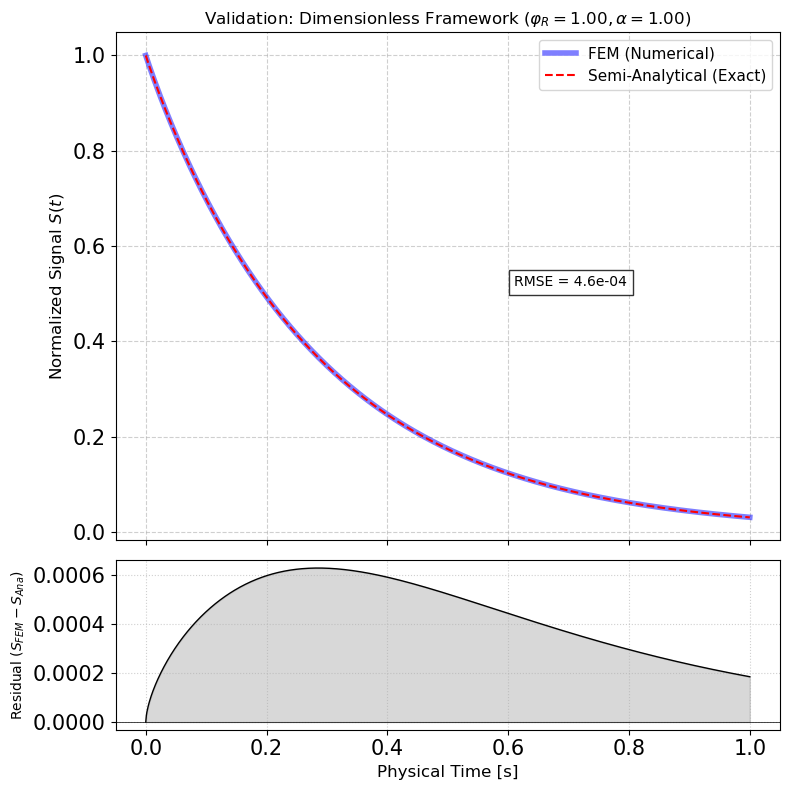

In [11]:
run_validation()

# Quartz : 1 - 4 $\mu$m / s

## 4um/s

In [ ]:
# =================================================================
# ---- I. Physical and Numerical Parameters ----
# =================================================================
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR) # Array of radii

# Physical constants
D    = 2.3e-9                          # [m^2/s] Diffusion coefficient
rho  = 4.e-6                          # [m/s] Surface relaxivity
T2B  = 2.0                             # [s] Bulk relaxation time
B0   = 0.05                            # [T] Field strength
T    = 303.15                          # [K] Temperature
fluid= "water"

# Time parameters
t0, tf, dt = 0.0, 10.0, 1e-3            # [s] Start, end, and step time

# FEM Simulation Parameters
mesh_res = 300  # Mesh resolution (number of elements)
n_fields = 500  # Snapshot storage frequency (store_fields_every)
                # (Stores at i=0, 500, 1000, ..., 10000)
                # (Corresponds to t=0.0, 0.5, 1.0, ..., 10.0 s)

# =================================================================
# ---- II. Prepare Storage and Directories ----
# =================================================================

# Create output directory for profiles
output_folder = f'profile_FEM_rho{rho*1e6}ums'
os.makedirs(output_folder, exist_ok=True)
print(f"Profile output directory: {output_folder}")

# In-memory storage for *decays*
all_decay_data = {}
# In-memory storage for *snapshots* (FEniCS objects, for plotting)
all_snapshots_data = {} 

# Calculate snapshot times ONCE
# This is crucial for consistency in naming and analysis
nt = int(round((tf - t0) / dt)) + 1
t_full_vector = np.linspace(t0, tf, nt)
snap_indices = list(range(0, nt, n_fields))
snap_times = t_full_vector[snap_indices]
print(f"Will store {len(snap_times)} snapshots at times: {np.round(snap_times, 2)}")

print("\n--- Starting radius sweep ---")

# =================================================================
# ---- III. Main Simulation Loop ----
# =================================================================

for i, R in enumerate(radius):
    print(f"  Processing Radius R = {R:.3e} m ({i+1}/{nR})...")
    
    # Run FEM simulation for this radius
    # We request 'all' data, which includes the list of 'snaps'
    t_vol, m_vol, s_vol, M_vol, snaps = FEM_NMR(
        radius=R, mesh_res=mesh_res,
        diffusion=D, rho=rho, T2B=T2B,
        B_0=B0, Temp=T, fluid=fluid,
        t_0=t0, t_f=tf, dt=dt,
        volume_=True,                 # Return physical M(t)
        normalize=False,             # Return unnormalized signal
        return_data='all',
        linear_solver='mumps',       # Direct solver
        progress=False,              # Disable internal progress bar
        store_fields_every=n_fields,
        V_degree=2,                  # Quadratic elements
        comm=MPI.comm_self,          # Force serial execution
    )
    
    # --- 3a. Store decay data ---
    if i == 0:
        # Store time vector (only first time, it's the same for all)
        all_decay_data['time_s'] = t_vol
        
    all_decay_data[f'M(t)_R={R:.3e}m'] = s_vol

    # --- 3b. (CONSOLIDATED SAVE) Save all profiles for THIS radius ---
    
    # This dictionary will hold all profile data for this radius
    # It will be converted to a pandas DataFrame
    profile_data_for_this_R = {}
    
    for j, s_object in enumerate(snaps):
        # Get the time corresponding to this snapshot
        t_snap = snap_times[j]
        
        # Extract (r, m) data from the FEniCS object
        x_r, m_r = profile_1d_dof(s_object)
        
        if j == 0:
            # On the first snapshot (t=0.0), store the 'r' coordinate vector.
            profile_data_for_this_R['r'] = x_r
        
        # Store the magnetization profile, naming the column by its time
        col_name = f'{t_snap:.2f} s'
        profile_data_for_this_R[col_name] = m_r

    # Convert the dictionary (with 'r' and all 'm(t=...)' columns) to a DataFrame.
    profile_df = pd.DataFrame(profile_data_for_this_R)
    
    # Create the NEW, consolidated filename (one per radius)
    file_name_only = f'profile_FEM_R_{R:.3e}m.csv'
    profile_filename = os.path.join(output_folder, file_name_only)
    
    # Save the single, consolidated CSV file for this radius
    profile_df.to_csv(profile_filename, index=False)

    # --- 3c. Store snapshot objects in RAM (for plotting later) ---
    all_snapshots_data[R] = snaps

print("--- Radius sweep completed ---")

# =================================================================
# ---- IV. Save Consolidated Decay Data ----
# =================================================================

# Convert decay dictionary to Pandas DataFrame
decay_dataframe = pd.DataFrame(all_decay_data)

# Save all decays to a SINGLE CSV file
decay_output_file = f'all_decays_FEM_rho{rho*1e6}ums.csv'
decay_dataframe.to_csv(decay_output_file, index=False)
print(f"\nAll M(t) decays saved to: {decay_output_file}")


# =================================================================
# ---- V. Visualization ----
# =================================================================

print("Generating plots...")

# --- 5a. Plot of ALL M(t) decays ---
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, nR)) # Colormap

for i, R in enumerate(radius):
    col_name = f'M(t)_R={R:.3e}m'
    plt.plot(all_decay_data['time_s'], 
             all_decay_data[col_name], 
             color=colors[i], 
             label=f'R = {R*1e6:.1f} µm')

plt.xlabel("Time [s]")
plt.ylabel("Total Magnetization M(t) [a.u.]")
plt.title(f"FEM Decays for $\\rho = {rho*1e6}$ µm/s")
plt.grid(True, linestyle='--', alpha=0.6)

# Use a colorbar instead of a legend if too many lines
if nR <= 10:
    plt.legend()
else:
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", 
                 norm=plt.Normalize(vmin=R_min*1e6, vmax=R_max*1e6)), 
                 ax=plt.gca(), label='Radius [µm]')
plt.tight_layout()
plt.show()


# --- 5b. Plot of ALL m(r,t) snapshots for ONE radius ---
# (Plotting snapshots from the LAST radius)

R_to_plot = radius[-1] # Select the last radius
snaps_to_plot = all_snapshots_data[R_to_plot]
t_norm = np.linspace(0, 1, len(snaps_to_plot)) # For colormap normalization

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(t_norm) # Use a different colormap

print(f"Plotting {len(snaps_to_plot)} profiles for R = {R_to_plot:.3e} m...")
for j, s_object in enumerate(snaps_to_plot):
    t_snap = snap_times[j]
    x_r, m_r = profile_1d_dof(s_object)
    
    # Normalize r to plot from 0 to 1
    r_norm = x_r / R_to_plot 
    
    plt.plot(r_norm, m_r, color=colors[j], label=f't = {t_snap:.2f} s')

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Magnetization m(r,t) [a.u.]")
plt.title(f"Magnetization Profiles (Snapshots) for R = {R_to_plot*1e6:.1f} µm")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Add a colorbar for time
plt.colorbar(plt.cm.ScalarMappable(cmap="plasma", 
             norm=plt.Normalize(vmin=t0, vmax=tf)), 
             ax=plt.gca(), label='Time [s]')
plt.tight_layout()
plt.show()

print("\n--- Process finished ---")

## 1 um/s

In [ ]:
# =================================================================
# ---- I. Physical and Numerical Parameters ----
# =================================================================
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR) # Array of radii

# Physical constants
D    = 2.3e-9                          # [m^2/s] Diffusion coefficient
rho  = 1.e-6                          # [m/s] Surface relaxivity
T2B  = 2.0                             # [s] Bulk relaxation time
B0   = 0.05                            # [T] Field strength
T    = 303.15                          # [K] Temperature
fluid= "water"

# Time parameters
t0, tf, dt = 0.0, 10.0, 1e-3            # [s] Start, end, and step time

# FEM Simulation Parameters
mesh_res = 300  # Mesh resolution (number of elements)
n_fields = 500  # Snapshot storage frequency (store_fields_every)
                # (Stores at i=0, 500, 1000, ..., 10000)
                # (Corresponds to t=0.0, 0.5, 1.0, ..., 10.0 s)

# =================================================================
# ---- II. Prepare Storage and Directories ----
# =================================================================

# Create output directory for profiles
output_folder = f'profile_FEM_rho{rho*1e6}ums'
os.makedirs(output_folder, exist_ok=True)
print(f"Profile output directory: {output_folder}")

# In-memory storage for *decays*
all_decay_data = {}
# In-memory storage for *snapshots* (FEniCS objects, for plotting)
all_snapshots_data = {} 

# Calculate snapshot times ONCE
# This is crucial for consistency in naming and analysis
nt = int(round((tf - t0) / dt)) + 1
t_full_vector = np.linspace(t0, tf, nt)
snap_indices = list(range(0, nt, n_fields))
snap_times = t_full_vector[snap_indices]
print(f"Will store {len(snap_times)} snapshots at times: {np.round(snap_times, 2)}")

print("\n--- Starting radius sweep ---")

# =================================================================
# ---- III. Main Simulation Loop ----
# =================================================================

for i, R in enumerate(radius):
    print(f"  Processing Radius R = {R:.3e} m ({i+1}/{nR})...")
    
    # Run FEM simulation for this radius
    # We request 'all' data, which includes the list of 'snaps'
    t_vol, m_vol, s_vol, M_vol, snaps = FEM_NMR(
        radius=R, mesh_res=mesh_res,
        diffusion=D, rho=rho, T2B=T2B,
        B_0=B0, Temp=T, fluid=fluid,
        t_0=t0, t_f=tf, dt=dt,
        volume_=True,                 # Return physical M(t)
        normalize=False,             # Return unnormalized signal
        return_data='all',
        linear_solver='mumps',       # Direct solver
        progress=False,              # Disable internal progress bar
        store_fields_every=n_fields,
        V_degree=2,                  # Quadratic elements
        comm=MPI.comm_self,          # Force serial execution
    )
    
    # --- 3a. Store decay data ---
    if i == 0:
        # Store time vector (only first time, it's the same for all)
        all_decay_data['time_s'] = t_vol
        
    all_decay_data[f'M(t)_R={R:.3e}m'] = s_vol

    # --- 3b. (CONSOLIDATED SAVE) Save all profiles for THIS radius ---
    
    # This dictionary will hold all profile data for this radius
    # It will be converted to a pandas DataFrame
    profile_data_for_this_R = {}
    
    for j, s_object in enumerate(snaps):
        # Get the time corresponding to this snapshot
        t_snap = snap_times[j]
        
        # Extract (r, m) data from the FEniCS object
        x_r, m_r = profile_1d_dof(s_object)
        
        if j == 0:
            # On the first snapshot (t=0.0), store the 'r' coordinate vector.
            profile_data_for_this_R['r'] = x_r
        
        # Store the magnetization profile, naming the column by its time
        col_name = f'{t_snap:.2f} s'
        profile_data_for_this_R[col_name] = m_r

    # Convert the dictionary (with 'r' and all 'm(t=...)' columns) to a DataFrame.
    profile_df = pd.DataFrame(profile_data_for_this_R)
    
    # Create the NEW, consolidated filename (one per radius)
    file_name_only = f'profile_FEM_R_{R:.3e}m.csv'
    profile_filename = os.path.join(output_folder, file_name_only)
    
    # Save the single, consolidated CSV file for this radius
    profile_df.to_csv(profile_filename, index=False)

    # --- 3c. Store snapshot objects in RAM (for plotting later) ---
    all_snapshots_data[R] = snaps

print("--- Radius sweep completed ---")

# =================================================================
# ---- IV. Save Consolidated Decay Data ----
# =================================================================

# Convert decay dictionary to Pandas DataFrame
decay_dataframe = pd.DataFrame(all_decay_data)

# Save all decays to a SINGLE CSV file
decay_output_file = f'all_decays_FEM_rho{rho*1e6}ums.csv'
decay_dataframe.to_csv(decay_output_file, index=False)
print(f"\nAll M(t) decays saved to: {decay_output_file}")


# =================================================================
# ---- V. Visualization ----
# =================================================================

print("Generating plots...")

# --- 5a. Plot of ALL M(t) decays ---
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, nR)) # Colormap

for i, R in enumerate(radius):
    col_name = f'M(t)_R={R:.3e}m'
    plt.plot(all_decay_data['time_s'], 
             all_decay_data[col_name], 
             color=colors[i], 
             label=f'R = {R*1e6:.1f} µm')

plt.xlabel("Time [s]")
plt.ylabel("Total Magnetization M(t) [a.u.]")
plt.title(f"FEM Decays for $\\rho = {rho*1e6}$ µm/s")
plt.grid(True, linestyle='--', alpha=0.6)

# Use a colorbar instead of a legend if too many lines
if nR <= 10:
    plt.legend()
else:
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", 
                 norm=plt.Normalize(vmin=R_min*1e6, vmax=R_max*1e6)), 
                 ax=plt.gca(), label='Radius [µm]')
plt.tight_layout()
plt.show()


# --- 5b. Plot of ALL m(r,t) snapshots for ONE radius ---
# (Plotting snapshots from the LAST radius)

R_to_plot = radius[-1] # Select the last radius
snaps_to_plot = all_snapshots_data[R_to_plot]
t_norm = np.linspace(0, 1, len(snaps_to_plot)) # For colormap normalization

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(t_norm) # Use a different colormap

print(f"Plotting {len(snaps_to_plot)} profiles for R = {R_to_plot:.3e} m...")
for j, s_object in enumerate(snaps_to_plot):
    t_snap = snap_times[j]
    x_r, m_r = profile_1d_dof(s_object)
    
    # Normalize r to plot from 0 to 1
    r_norm = x_r / R_to_plot 
    
    plt.plot(r_norm, m_r, color=colors[j], label=f't = {t_snap:.2f} s')

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Magnetization m(r,t) [a.u.]")
plt.title(f"Magnetization Profiles (Snapshots) for R = {R_to_plot*1e6:.1f} µm")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Add a colorbar for time
plt.colorbar(plt.cm.ScalarMappable(cmap="plasma", 
             norm=plt.Normalize(vmin=t0, vmax=tf)), 
             ax=plt.gca(), label='Time [s]')
plt.tight_layout()
plt.show()

print("\n--- Process finished ---")

# Sandstone 20 - 40 $\mu$m/s

## 20 um/s

In [ ]:
# =================================================================
# ---- I. Physical and Numerical Parameters ----
# =================================================================
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR) # Array of radii

# Physical constants
D    = 2.3e-9                          # [m^2/s] Diffusion coefficient
rho  = 20.e-6                          # [m/s] Surface relaxivity
T2B  = 2.0                             # [s] Bulk relaxation time
B0   = 0.05                            # [T] Field strength
T    = 303.15                          # [K] Temperature
fluid= "water"

# Time parameters
t0, tf, dt = 0.0, 10.0, 1e-3            # [s] Start, end, and step time

# FEM Simulation Parameters
mesh_res = 300  # Mesh resolution (number of elements)
n_fields = 500  # Snapshot storage frequency (store_fields_every)
                # (Stores at i=0, 500, 1000, ..., 10000)
                # (Corresponds to t=0.0, 0.5, 1.0, ..., 10.0 s)

# =================================================================
# ---- II. Prepare Storage and Directories ----
# =================================================================

# Create output directory for profiles
output_folder = f'profile_FEM_rho{rho*1e6}ums'
os.makedirs(output_folder, exist_ok=True)
print(f"Profile output directory: {output_folder}")

# In-memory storage for *decays*
all_decay_data = {}
# In-memory storage for *snapshots* (FEniCS objects, for plotting)
all_snapshots_data = {} 

# Calculate snapshot times ONCE
# This is crucial for consistency in naming and analysis
nt = int(round((tf - t0) / dt)) + 1
t_full_vector = np.linspace(t0, tf, nt)
snap_indices = list(range(0, nt, n_fields))
snap_times = t_full_vector[snap_indices]
print(f"Will store {len(snap_times)} snapshots at times: {np.round(snap_times, 2)}")

print("\n--- Starting radius sweep ---")

# =================================================================
# ---- III. Main Simulation Loop ----
# =================================================================

for i, R in enumerate(radius):
    print(f"  Processing Radius R = {R:.3e} m ({i+1}/{nR})...")
    
    # Run FEM simulation for this radius
    # We request 'all' data, which includes the list of 'snaps'
    t_vol, m_vol, s_vol, M_vol, snaps = FEM_NMR(
        radius=R, mesh_res=mesh_res,
        diffusion=D, rho=rho, T2B=T2B,
        B_0=B0, Temp=T, fluid=fluid,
        t_0=t0, t_f=tf, dt=dt,
        volume_=True,                 # Return physical M(t)
        normalize=False,             # Return unnormalized signal
        return_data='all',
        linear_solver='mumps',       # Direct solver
        progress=False,              # Disable internal progress bar
        store_fields_every=n_fields,
        V_degree=2,                  # Quadratic elements
        comm=MPI.comm_self,          # Force serial execution
    )
    
    # --- 3a. Store decay data ---
    if i == 0:
        # Store time vector (only first time, it's the same for all)
        all_decay_data['time_s'] = t_vol
        
    all_decay_data[f'M(t)_R={R:.3e}m'] = s_vol

    # --- 3b. (CONSOLIDATED SAVE) Save all profiles for THIS radius ---
    
    # This dictionary will hold all profile data for this radius
    # It will be converted to a pandas DataFrame
    profile_data_for_this_R = {}
    
    for j, s_object in enumerate(snaps):
        # Get the time corresponding to this snapshot
        t_snap = snap_times[j]
        
        # Extract (r, m) data from the FEniCS object
        x_r, m_r = profile_1d_dof(s_object)
        
        if j == 0:
            # On the first snapshot (t=0.0), store the 'r' coordinate vector.
            profile_data_for_this_R['r'] = x_r
        
        # Store the magnetization profile, naming the column by its time
        col_name = f'{t_snap:.2f} s'
        profile_data_for_this_R[col_name] = m_r

    # Convert the dictionary (with 'r' and all 'm(t=...)' columns) to a DataFrame.
    profile_df = pd.DataFrame(profile_data_for_this_R)
    
    # Create the NEW, consolidated filename (one per radius)
    file_name_only = f'profile_FEM_R_{R:.3e}m.csv'
    profile_filename = os.path.join(output_folder, file_name_only)
    
    # Save the single, consolidated CSV file for this radius
    profile_df.to_csv(profile_filename, index=False)

    # --- 3c. Store snapshot objects in RAM (for plotting later) ---
    all_snapshots_data[R] = snaps

print("--- Radius sweep completed ---")

# =================================================================
# ---- IV. Save Consolidated Decay Data ----
# =================================================================

# Convert decay dictionary to Pandas DataFrame
decay_dataframe = pd.DataFrame(all_decay_data)

# Save all decays to a SINGLE CSV file
decay_output_file = f'all_decays_FEM_rho{rho*1e6}ums.csv'
decay_dataframe.to_csv(decay_output_file, index=False)
print(f"\nAll M(t) decays saved to: {decay_output_file}")


# =================================================================
# ---- V. Visualization ----
# =================================================================

print("Generating plots...")

# --- 5a. Plot of ALL M(t) decays ---
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, nR)) # Colormap

for i, R in enumerate(radius):
    col_name = f'M(t)_R={R:.3e}m'
    plt.plot(all_decay_data['time_s'], 
             all_decay_data[col_name], 
             color=colors[i], 
             label=f'R = {R*1e6:.1f} µm')

plt.xlabel("Time [s]")
plt.ylabel("Total Magnetization M(t) [a.u.]")
plt.title(f"FEM Decays for $\\rho = {rho*1e6}$ µm/s")
plt.grid(True, linestyle='--', alpha=0.6)

# Use a colorbar instead of a legend if too many lines
if nR <= 10:
    plt.legend()
else:
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", 
                 norm=plt.Normalize(vmin=R_min*1e6, vmax=R_max*1e6)), 
                 ax=plt.gca(), label='Radius [µm]')
plt.tight_layout()
plt.show()


# --- 5b. Plot of ALL m(r,t) snapshots for ONE radius ---
# (Plotting snapshots from the LAST radius)

R_to_plot = radius[-1] # Select the last radius
snaps_to_plot = all_snapshots_data[R_to_plot]
t_norm = np.linspace(0, 1, len(snaps_to_plot)) # For colormap normalization

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(t_norm) # Use a different colormap

print(f"Plotting {len(snaps_to_plot)} profiles for R = {R_to_plot:.3e} m...")
for j, s_object in enumerate(snaps_to_plot):
    t_snap = snap_times[j]
    x_r, m_r = profile_1d_dof(s_object)
    
    # Normalize r to plot from 0 to 1
    r_norm = x_r / R_to_plot 
    
    plt.plot(r_norm, m_r, color=colors[j], label=f't = {t_snap:.2f} s')

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Magnetization m(r,t) [a.u.]")
plt.title(f"Magnetization Profiles (Snapshots) for R = {R_to_plot*1e6:.1f} µm")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Add a colorbar for time
plt.colorbar(plt.cm.ScalarMappable(cmap="plasma", 
             norm=plt.Normalize(vmin=t0, vmax=tf)), 
             ax=plt.gca(), label='Time [s]')
plt.tight_layout()
plt.show()

print("\n--- Process finished ---")

## 25 um/s

In [ ]:
# =================================================================
# ---- I. Physical and Numerical Parameters ----
# =================================================================
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR) # Array of radii

# Physical constants
D    = 2.3e-9                          # [m^2/s] Diffusion coefficient
rho  = 25.e-6                          # [m/s] Surface relaxivity
T2B  = 2.0                             # [s] Bulk relaxation time
B0   = 0.05                            # [T] Field strength
T    = 303.15                          # [K] Temperature
fluid= "water"

# Time parameters
t0, tf, dt = 0.0, 10.0, 1e-3            # [s] Start, end, and step time

# FEM Simulation Parameters
mesh_res = 300  # Mesh resolution (number of elements)
n_fields = 500  # Snapshot storage frequency (store_fields_every)
                # (Stores at i=0, 500, 1000, ..., 10000)
                # (Corresponds to t=0.0, 0.5, 1.0, ..., 10.0 s)

# =================================================================
# ---- II. Prepare Storage and Directories ----
# =================================================================

# Create output directory for profiles
output_folder = f'profile_FEM_rho{rho*1e6}ums'
os.makedirs(output_folder, exist_ok=True)
print(f"Profile output directory: {output_folder}")

# In-memory storage for *decays*
all_decay_data = {}
# In-memory storage for *snapshots* (FEniCS objects, for plotting)
all_snapshots_data = {} 

# Calculate snapshot times ONCE
# This is crucial for consistency in naming and analysis
nt = int(round((tf - t0) / dt)) + 1
t_full_vector = np.linspace(t0, tf, nt)
snap_indices = list(range(0, nt, n_fields))
snap_times = t_full_vector[snap_indices]
print(f"Will store {len(snap_times)} snapshots at times: {np.round(snap_times, 2)}")

print("\n--- Starting radius sweep ---")

# =================================================================
# ---- III. Main Simulation Loop ----
# =================================================================

for i, R in enumerate(radius):
    print(f"  Processing Radius R = {R:.3e} m ({i+1}/{nR})...")
    
    # Run FEM simulation for this radius
    # We request 'all' data, which includes the list of 'snaps'
    t_vol, m_vol, s_vol, M_vol, snaps = FEM_NMR(
        radius=R, mesh_res=mesh_res,
        diffusion=D, rho=rho, T2B=T2B,
        B_0=B0, Temp=T, fluid=fluid,
        t_0=t0, t_f=tf, dt=dt,
        volume_=True,                 # Return physical M(t)
        normalize=False,             # Return unnormalized signal
        return_data='all',
        linear_solver='mumps',       # Direct solver
        progress=False,              # Disable internal progress bar
        store_fields_every=n_fields,
        V_degree=2,                  # Quadratic elements
        comm=MPI.comm_self,          # Force serial execution
    )
    
    # --- 3a. Store decay data ---
    if i == 0:
        # Store time vector (only first time, it's the same for all)
        all_decay_data['time_s'] = t_vol
        
    all_decay_data[f'M(t)_R={R:.3e}m'] = s_vol

    # --- 3b. (CONSOLIDATED SAVE) Save all profiles for THIS radius ---
    
    # This dictionary will hold all profile data for this radius
    # It will be converted to a pandas DataFrame
    profile_data_for_this_R = {}
    
    for j, s_object in enumerate(snaps):
        # Get the time corresponding to this snapshot
        t_snap = snap_times[j]
        
        # Extract (r, m) data from the FEniCS object
        x_r, m_r = profile_1d_dof(s_object)
        
        if j == 0:
            # On the first snapshot (t=0.0), store the 'r' coordinate vector.
            profile_data_for_this_R['r'] = x_r
        
        # Store the magnetization profile, naming the column by its time
        col_name = f'{t_snap:.2f} s'
        profile_data_for_this_R[col_name] = m_r

    # Convert the dictionary (with 'r' and all 'm(t=...)' columns) to a DataFrame.
    profile_df = pd.DataFrame(profile_data_for_this_R)
    
    # Create the NEW, consolidated filename (one per radius)
    file_name_only = f'profile_FEM_R_{R:.3e}m.csv'
    profile_filename = os.path.join(output_folder, file_name_only)
    
    # Save the single, consolidated CSV file for this radius
    profile_df.to_csv(profile_filename, index=False)

    # --- 3c. Store snapshot objects in RAM (for plotting later) ---
    all_snapshots_data[R] = snaps

print("--- Radius sweep completed ---")

# =================================================================
# ---- IV. Save Consolidated Decay Data ----
# =================================================================

# Convert decay dictionary to Pandas DataFrame
decay_dataframe = pd.DataFrame(all_decay_data)

# Save all decays to a SINGLE CSV file
decay_output_file = f'all_decays_FEM_rho{rho*1e6}ums.csv'
decay_dataframe.to_csv(decay_output_file, index=False)
print(f"\nAll M(t) decays saved to: {decay_output_file}")


# =================================================================
# ---- V. Visualization ----
# =================================================================

print("Generating plots...")

# --- 5a. Plot of ALL M(t) decays ---
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, nR)) # Colormap

for i, R in enumerate(radius):
    col_name = f'M(t)_R={R:.3e}m'
    plt.plot(all_decay_data['time_s'], 
             all_decay_data[col_name], 
             color=colors[i], 
             label=f'R = {R*1e6:.1f} µm')

plt.xlabel("Time [s]")
plt.ylabel("Total Magnetization M(t) [a.u.]")
plt.title(f"FEM Decays for $\\rho = {rho*1e6}$ µm/s")
plt.grid(True, linestyle='--', alpha=0.6)

# Use a colorbar instead of a legend if too many lines
if nR <= 10:
    plt.legend()
else:
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", 
                 norm=plt.Normalize(vmin=R_min*1e6, vmax=R_max*1e6)), 
                 ax=plt.gca(), label='Radius [µm]')
plt.tight_layout()
plt.show()


# --- 5b. Plot of ALL m(r,t) snapshots for ONE radius ---
# (Plotting snapshots from the LAST radius)

R_to_plot = radius[-1] # Select the last radius
snaps_to_plot = all_snapshots_data[R_to_plot]
t_norm = np.linspace(0, 1, len(snaps_to_plot)) # For colormap normalization

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(t_norm) # Use a different colormap

print(f"Plotting {len(snaps_to_plot)} profiles for R = {R_to_plot:.3e} m...")
for j, s_object in enumerate(snaps_to_plot):
    t_snap = snap_times[j]
    x_r, m_r = profile_1d_dof(s_object)
    
    # Normalize r to plot from 0 to 1
    r_norm = x_r / R_to_plot 
    
    plt.plot(r_norm, m_r, color=colors[j], label=f't = {t_snap:.2f} s')

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Magnetization m(r,t) [a.u.]")
plt.title(f"Magnetization Profiles (Snapshots) for R = {R_to_plot*1e6:.1f} µm")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Add a colorbar for time
plt.colorbar(plt.cm.ScalarMappable(cmap="plasma", 
             norm=plt.Normalize(vmin=t0, vmax=tf)), 
             ax=plt.gca(), label='Time [s]')
plt.tight_layout()
plt.show()

print("\n--- Process finished ---")

## 30 um/s

In [ ]:
# =================================================================
# ---- I. Physical and Numerical Parameters ----
# =================================================================
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR) # Array of radii

# Physical constants
D    = 2.3e-9                          # [m^2/s] Diffusion coefficient
rho  = 30.e-6                          # [m/s] Surface relaxivity
T2B  = 2.0                             # [s] Bulk relaxation time
B0   = 0.05                            # [T] Field strength
T    = 303.15                          # [K] Temperature
fluid= "water"

# Time parameters
t0, tf, dt = 0.0, 10.0, 1e-3            # [s] Start, end, and step time

# FEM Simulation Parameters
mesh_res = 300  # Mesh resolution (number of elements)
n_fields = 500  # Snapshot storage frequency (store_fields_every)
                # (Stores at i=0, 500, 1000, ..., 10000)
                # (Corresponds to t=0.0, 0.5, 1.0, ..., 10.0 s)

# =================================================================
# ---- II. Prepare Storage and Directories ----
# =================================================================

# Create output directory for profiles
output_folder = f'profile_FEM_rho{rho*1e6}ums'
os.makedirs(output_folder, exist_ok=True)
print(f"Profile output directory: {output_folder}")

# In-memory storage for *decays*
all_decay_data = {}
# In-memory storage for *snapshots* (FEniCS objects, for plotting)
all_snapshots_data = {} 

# Calculate snapshot times ONCE
# This is crucial for consistency in naming and analysis
nt = int(round((tf - t0) / dt)) + 1
t_full_vector = np.linspace(t0, tf, nt)
snap_indices = list(range(0, nt, n_fields))
snap_times = t_full_vector[snap_indices]
print(f"Will store {len(snap_times)} snapshots at times: {np.round(snap_times, 2)}")

print("\n--- Starting radius sweep ---")

# =================================================================
# ---- III. Main Simulation Loop ----
# =================================================================

for i, R in enumerate(radius):
    print(f"  Processing Radius R = {R:.3e} m ({i+1}/{nR})...")
    
    # Run FEM simulation for this radius
    # We request 'all' data, which includes the list of 'snaps'
    t_vol, m_vol, s_vol, M_vol, snaps = FEM_NMR(
        radius=R, mesh_res=mesh_res,
        diffusion=D, rho=rho, T2B=T2B,
        B_0=B0, Temp=T, fluid=fluid,
        t_0=t0, t_f=tf, dt=dt,
        volume_=True,                 # Return physical M(t)
        normalize=False,             # Return unnormalized signal
        return_data='all',
        linear_solver='mumps',       # Direct solver
        progress=False,              # Disable internal progress bar
        store_fields_every=n_fields,
        V_degree=2,                  # Quadratic elements
        comm=MPI.comm_self,          # Force serial execution
    )
    
    # --- 3a. Store decay data ---
    if i == 0:
        # Store time vector (only first time, it's the same for all)
        all_decay_data['time_s'] = t_vol
        
    all_decay_data[f'M(t)_R={R:.3e}m'] = s_vol

    # --- 3b. (CONSOLIDATED SAVE) Save all profiles for THIS radius ---
    
    # This dictionary will hold all profile data for this radius
    # It will be converted to a pandas DataFrame
    profile_data_for_this_R = {}
    
    for j, s_object in enumerate(snaps):
        # Get the time corresponding to this snapshot
        t_snap = snap_times[j]
        
        # Extract (r, m) data from the FEniCS object
        x_r, m_r = profile_1d_dof(s_object)
        
        if j == 0:
            # On the first snapshot (t=0.0), store the 'r' coordinate vector.
            profile_data_for_this_R['r'] = x_r
        
        # Store the magnetization profile, naming the column by its time
        col_name = f'{t_snap:.2f} s'
        profile_data_for_this_R[col_name] = m_r

    # Convert the dictionary (with 'r' and all 'm(t=...)' columns) to a DataFrame.
    profile_df = pd.DataFrame(profile_data_for_this_R)
    
    # Create the NEW, consolidated filename (one per radius)
    file_name_only = f'profile_FEM_R_{R:.3e}m.csv'
    profile_filename = os.path.join(output_folder, file_name_only)
    
    # Save the single, consolidated CSV file for this radius
    profile_df.to_csv(profile_filename, index=False)

    # --- 3c. Store snapshot objects in RAM (for plotting later) ---
    all_snapshots_data[R] = snaps

print("--- Radius sweep completed ---")

# =================================================================
# ---- IV. Save Consolidated Decay Data ----
# =================================================================

# Convert decay dictionary to Pandas DataFrame
decay_dataframe = pd.DataFrame(all_decay_data)

# Save all decays to a SINGLE CSV file
decay_output_file = f'all_decays_FEM_rho{rho*1e6}ums.csv'
decay_dataframe.to_csv(decay_output_file, index=False)
print(f"\nAll M(t) decays saved to: {decay_output_file}")


# =================================================================
# ---- V. Visualization ----
# =================================================================

print("Generating plots...")

# --- 5a. Plot of ALL M(t) decays ---
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, nR)) # Colormap

for i, R in enumerate(radius):
    col_name = f'M(t)_R={R:.3e}m'
    plt.plot(all_decay_data['time_s'], 
             all_decay_data[col_name], 
             color=colors[i], 
             label=f'R = {R*1e6:.1f} µm')

plt.xlabel("Time [s]")
plt.ylabel("Total Magnetization M(t) [a.u.]")
plt.title(f"FEM Decays for $\\rho = {rho*1e6}$ µm/s")
plt.grid(True, linestyle='--', alpha=0.6)

# Use a colorbar instead of a legend if too many lines
if nR <= 10:
    plt.legend()
else:
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", 
                 norm=plt.Normalize(vmin=R_min*1e6, vmax=R_max*1e6)), 
                 ax=plt.gca(), label='Radius [µm]')
plt.tight_layout()
plt.show()


# --- 5b. Plot of ALL m(r,t) snapshots for ONE radius ---
# (Plotting snapshots from the LAST radius)

R_to_plot = radius[-1] # Select the last radius
snaps_to_plot = all_snapshots_data[R_to_plot]
t_norm = np.linspace(0, 1, len(snaps_to_plot)) # For colormap normalization

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(t_norm) # Use a different colormap

print(f"Plotting {len(snaps_to_plot)} profiles for R = {R_to_plot:.3e} m...")
for j, s_object in enumerate(snaps_to_plot):
    t_snap = snap_times[j]
    x_r, m_r = profile_1d_dof(s_object)
    
    # Normalize r to plot from 0 to 1
    r_norm = x_r / R_to_plot 
    
    plt.plot(r_norm, m_r, color=colors[j], label=f't = {t_snap:.2f} s')

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Magnetization m(r,t) [a.u.]")
plt.title(f"Magnetization Profiles (Snapshots) for R = {R_to_plot*1e6:.1f} µm")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Add a colorbar for time
plt.colorbar(plt.cm.ScalarMappable(cmap="plasma", 
             norm=plt.Normalize(vmin=t0, vmax=tf)), 
             ax=plt.gca(), label='Time [s]')
plt.tight_layout()
plt.show()

print("\n--- Process finished ---")

## 35 um/s

In [ ]:
# =================================================================
# ---- I. Physical and Numerical Parameters ----
# =================================================================
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR) # Array of radii

# Physical constants
D    = 2.3e-9                          # [m^2/s] Diffusion coefficient
rho  = 35.e-6                          # [m/s] Surface relaxivity
T2B  = 2.0                             # [s] Bulk relaxation time
B0   = 0.05                            # [T] Field strength
T    = 303.15                          # [K] Temperature
fluid= "water"

# Time parameters
t0, tf, dt = 0.0, 10.0, 1e-3            # [s] Start, end, and step time

# FEM Simulation Parameters
mesh_res = 300  # Mesh resolution (number of elements)
n_fields = 500  # Snapshot storage frequency (store_fields_every)
                # (Stores at i=0, 500, 1000, ..., 10000)
                # (Corresponds to t=0.0, 0.5, 1.0, ..., 10.0 s)

# =================================================================
# ---- II. Prepare Storage and Directories ----
# =================================================================

# Create output directory for profiles
output_folder = f'profile_FEM_rho{rho*1e6}ums'
os.makedirs(output_folder, exist_ok=True)
print(f"Profile output directory: {output_folder}")

# In-memory storage for *decays*
all_decay_data = {}
# In-memory storage for *snapshots* (FEniCS objects, for plotting)
all_snapshots_data = {} 

# Calculate snapshot times ONCE
# This is crucial for consistency in naming and analysis
nt = int(round((tf - t0) / dt)) + 1
t_full_vector = np.linspace(t0, tf, nt)
snap_indices = list(range(0, nt, n_fields))
snap_times = t_full_vector[snap_indices]
print(f"Will store {len(snap_times)} snapshots at times: {np.round(snap_times, 2)}")

print("\n--- Starting radius sweep ---")

# =================================================================
# ---- III. Main Simulation Loop ----
# =================================================================

for i, R in enumerate(radius):
    print(f"  Processing Radius R = {R:.3e} m ({i+1}/{nR})...")
    
    # Run FEM simulation for this radius
    # We request 'all' data, which includes the list of 'snaps'
    t_vol, m_vol, s_vol, M_vol, snaps = FEM_NMR(
        radius=R, mesh_res=mesh_res,
        diffusion=D, rho=rho, T2B=T2B,
        B_0=B0, Temp=T, fluid=fluid,
        t_0=t0, t_f=tf, dt=dt,
        volume_=True,                 # Return physical M(t)
        normalize=False,             # Return unnormalized signal
        return_data='all',
        linear_solver='mumps',       # Direct solver
        progress=False,              # Disable internal progress bar
        store_fields_every=n_fields,
        V_degree=2,                  # Quadratic elements
        comm=MPI.comm_self,          # Force serial execution
    )
    
    # --- 3a. Store decay data ---
    if i == 0:
        # Store time vector (only first time, it's the same for all)
        all_decay_data['time_s'] = t_vol
        
    all_decay_data[f'M(t)_R={R:.3e}m'] = s_vol

    # --- 3b. (CONSOLIDATED SAVE) Save all profiles for THIS radius ---
    
    # This dictionary will hold all profile data for this radius
    # It will be converted to a pandas DataFrame
    profile_data_for_this_R = {}
    
    for j, s_object in enumerate(snaps):
        # Get the time corresponding to this snapshot
        t_snap = snap_times[j]
        
        # Extract (r, m) data from the FEniCS object
        x_r, m_r = profile_1d_dof(s_object)
        
        if j == 0:
            # On the first snapshot (t=0.0), store the 'r' coordinate vector.
            profile_data_for_this_R['r'] = x_r
        
        # Store the magnetization profile, naming the column by its time
        col_name = f'{t_snap:.2f} s'
        profile_data_for_this_R[col_name] = m_r

    # Convert the dictionary (with 'r' and all 'm(t=...)' columns) to a DataFrame.
    profile_df = pd.DataFrame(profile_data_for_this_R)
    
    # Create the NEW, consolidated filename (one per radius)
    file_name_only = f'profile_FEM_R_{R:.3e}m.csv'
    profile_filename = os.path.join(output_folder, file_name_only)
    
    # Save the single, consolidated CSV file for this radius
    profile_df.to_csv(profile_filename, index=False)

    # --- 3c. Store snapshot objects in RAM (for plotting later) ---
    all_snapshots_data[R] = snaps

print("--- Radius sweep completed ---")

# =================================================================
# ---- IV. Save Consolidated Decay Data ----
# =================================================================

# Convert decay dictionary to Pandas DataFrame
decay_dataframe = pd.DataFrame(all_decay_data)

# Save all decays to a SINGLE CSV file
decay_output_file = f'all_decays_FEM_rho{rho*1e6}ums.csv'
decay_dataframe.to_csv(decay_output_file, index=False)
print(f"\nAll M(t) decays saved to: {decay_output_file}")


# =================================================================
# ---- V. Visualization ----
# =================================================================

print("Generating plots...")

# --- 5a. Plot of ALL M(t) decays ---
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, nR)) # Colormap

for i, R in enumerate(radius):
    col_name = f'M(t)_R={R:.3e}m'
    plt.plot(all_decay_data['time_s'], 
             all_decay_data[col_name], 
             color=colors[i], 
             label=f'R = {R*1e6:.1f} µm')

plt.xlabel("Time [s]")
plt.ylabel("Total Magnetization M(t) [a.u.]")
plt.title(f"FEM Decays for $\\rho = {rho*1e6}$ µm/s")
plt.grid(True, linestyle='--', alpha=0.6)

# Use a colorbar instead of a legend if too many lines
if nR <= 10:
    plt.legend()
else:
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", 
                 norm=plt.Normalize(vmin=R_min*1e6, vmax=R_max*1e6)), 
                 ax=plt.gca(), label='Radius [µm]')
plt.tight_layout()
plt.show()


# --- 5b. Plot of ALL m(r,t) snapshots for ONE radius ---
# (Plotting snapshots from the LAST radius)

R_to_plot = radius[-1] # Select the last radius
snaps_to_plot = all_snapshots_data[R_to_plot]
t_norm = np.linspace(0, 1, len(snaps_to_plot)) # For colormap normalization

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(t_norm) # Use a different colormap

print(f"Plotting {len(snaps_to_plot)} profiles for R = {R_to_plot:.3e} m...")
for j, s_object in enumerate(snaps_to_plot):
    t_snap = snap_times[j]
    x_r, m_r = profile_1d_dof(s_object)
    
    # Normalize r to plot from 0 to 1
    r_norm = x_r / R_to_plot 
    
    plt.plot(r_norm, m_r, color=colors[j], label=f't = {t_snap:.2f} s')

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Magnetization m(r,t) [a.u.]")
plt.title(f"Magnetization Profiles (Snapshots) for R = {R_to_plot*1e6:.1f} µm")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Add a colorbar for time
plt.colorbar(plt.cm.ScalarMappable(cmap="plasma", 
             norm=plt.Normalize(vmin=t0, vmax=tf)), 
             ax=plt.gca(), label='Time [s]')
plt.tight_layout()
plt.show()

print("\n--- Process finished ---")

## 40 um/s

In [ ]:
# =================================================================
# ---- I. Physical and Numerical Parameters ----
# =================================================================
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR) # Array of radii

# Physical constants
D    = 2.3e-9                          # [m^2/s] Diffusion coefficient
rho  = 40.e-6                          # [m/s] Surface relaxivity
T2B  = 2.0                             # [s] Bulk relaxation time
B0   = 0.05                            # [T] Field strength
T    = 303.15                          # [K] Temperature
fluid= "water"

# Time parameters
t0, tf, dt = 0.0, 10.0, 1e-3            # [s] Start, end, and step time

# FEM Simulation Parameters
mesh_res = 300  # Mesh resolution (number of elements)
n_fields = 500  # Snapshot storage frequency (store_fields_every)
                # (Stores at i=0, 500, 1000, ..., 10000)
                # (Corresponds to t=0.0, 0.5, 1.0, ..., 10.0 s)

# =================================================================
# ---- II. Prepare Storage and Directories ----
# =================================================================

# Create output directory for profiles
output_folder = f'profile_FEM_rho{rho*1e6}ums'
os.makedirs(output_folder, exist_ok=True)
print(f"Profile output directory: {output_folder}")

# In-memory storage for *decays*
all_decay_data = {}
# In-memory storage for *snapshots* (FEniCS objects, for plotting)
all_snapshots_data = {} 

# Calculate snapshot times ONCE
# This is crucial for consistency in naming and analysis
nt = int(round((tf - t0) / dt)) + 1
t_full_vector = np.linspace(t0, tf, nt)
snap_indices = list(range(0, nt, n_fields))
snap_times = t_full_vector[snap_indices]
print(f"Will store {len(snap_times)} snapshots at times: {np.round(snap_times, 2)}")

print("\n--- Starting radius sweep ---")

# =================================================================
# ---- III. Main Simulation Loop ----
# =================================================================

for i, R in enumerate(radius):
    print(f"  Processing Radius R = {R:.3e} m ({i+1}/{nR})...")
    
    # Run FEM simulation for this radius
    # We request 'all' data, which includes the list of 'snaps'
    t_vol, m_vol, s_vol, M_vol, snaps = FEM_NMR(
        radius=R, mesh_res=mesh_res,
        diffusion=D, rho=rho, T2B=T2B,
        B_0=B0, Temp=T, fluid=fluid,
        t_0=t0, t_f=tf, dt=dt,
        volume_=True,                 # Return physical M(t)
        normalize=False,             # Return unnormalized signal
        return_data='all',
        linear_solver='mumps',       # Direct solver
        progress=False,              # Disable internal progress bar
        store_fields_every=n_fields,
        V_degree=2,                  # Quadratic elements
        comm=MPI.comm_self,          # Force serial execution
    )
    
    # --- 3a. Store decay data ---
    if i == 0:
        # Store time vector (only first time, it's the same for all)
        all_decay_data['time_s'] = t_vol
        
    all_decay_data[f'M(t)_R={R:.3e}m'] = s_vol

    # --- 3b. (CONSOLIDATED SAVE) Save all profiles for THIS radius ---
    
    # This dictionary will hold all profile data for this radius
    # It will be converted to a pandas DataFrame
    profile_data_for_this_R = {}
    
    for j, s_object in enumerate(snaps):
        # Get the time corresponding to this snapshot
        t_snap = snap_times[j]
        
        # Extract (r, m) data from the FEniCS object
        x_r, m_r = profile_1d_dof(s_object)
        
        if j == 0:
            # On the first snapshot (t=0.0), store the 'r' coordinate vector.
            profile_data_for_this_R['r'] = x_r
        
        # Store the magnetization profile, naming the column by its time
        col_name = f'{t_snap:.2f} s'
        profile_data_for_this_R[col_name] = m_r

    # Convert the dictionary (with 'r' and all 'm(t=...)' columns) to a DataFrame.
    profile_df = pd.DataFrame(profile_data_for_this_R)
    
    # Create the NEW, consolidated filename (one per radius)
    file_name_only = f'profile_FEM_R_{R:.3e}m.csv'
    profile_filename = os.path.join(output_folder, file_name_only)
    
    # Save the single, consolidated CSV file for this radius
    profile_df.to_csv(profile_filename, index=False)

    # --- 3c. Store snapshot objects in RAM (for plotting later) ---
    all_snapshots_data[R] = snaps

print("--- Radius sweep completed ---")

# =================================================================
# ---- IV. Save Consolidated Decay Data ----
# =================================================================

# Convert decay dictionary to Pandas DataFrame
decay_dataframe = pd.DataFrame(all_decay_data)

# Save all decays to a SINGLE CSV file
decay_output_file = f'all_decays_FEM_rho{rho*1e6}ums.csv'
decay_dataframe.to_csv(decay_output_file, index=False)
print(f"\nAll M(t) decays saved to: {decay_output_file}")


# =================================================================
# ---- V. Visualization ----
# =================================================================

print("Generating plots...")

# --- 5a. Plot of ALL M(t) decays ---
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, nR)) # Colormap

for i, R in enumerate(radius):
    col_name = f'M(t)_R={R:.3e}m'
    plt.plot(all_decay_data['time_s'], 
             all_decay_data[col_name], 
             color=colors[i], 
             label=f'R = {R*1e6:.1f} µm')

plt.xlabel("Time [s]")
plt.ylabel("Total Magnetization M(t) [a.u.]")
plt.title(f"FEM Decays for $\\rho = {rho*1e6}$ µm/s")
plt.grid(True, linestyle='--', alpha=0.6)

# Use a colorbar instead of a legend if too many lines
if nR <= 10:
    plt.legend()
else:
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", 
                 norm=plt.Normalize(vmin=R_min*1e6, vmax=R_max*1e6)), 
                 ax=plt.gca(), label='Radius [µm]')
plt.tight_layout()
plt.show()


# --- 5b. Plot of ALL m(r,t) snapshots for ONE radius ---
# (Plotting snapshots from the LAST radius)

R_to_plot = radius[-1] # Select the last radius
snaps_to_plot = all_snapshots_data[R_to_plot]
t_norm = np.linspace(0, 1, len(snaps_to_plot)) # For colormap normalization

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(t_norm) # Use a different colormap

print(f"Plotting {len(snaps_to_plot)} profiles for R = {R_to_plot:.3e} m...")
for j, s_object in enumerate(snaps_to_plot):
    t_snap = snap_times[j]
    x_r, m_r = profile_1d_dof(s_object)
    
    # Normalize r to plot from 0 to 1
    r_norm = x_r / R_to_plot 
    
    plt.plot(r_norm, m_r, color=colors[j], label=f't = {t_snap:.2f} s')

plt.xlabel("Normalized Radius (r/R)")
plt.ylabel("Magnetization m(r,t) [a.u.]")
plt.title(f"Magnetization Profiles (Snapshots) for R = {R_to_plot*1e6:.1f} µm")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)

# Add a colorbar for time
plt.colorbar(plt.cm.ScalarMappable(cmap="plasma", 
             norm=plt.Normalize(vmin=t0, vmax=tf)), 
             ax=plt.gca(), label='Time [s]')
plt.tight_layout()
plt.show()

print("\n--- Process finished ---")

# All

In [ ]:
# ==========================================================
# ---- 1. Define Output Directory ----
# ==========================================================
figures_folder = 'figures_signal_FEM'
os.makedirs(figures_folder, exist_ok=True)
print(f"Output directory ensured: {figures_folder}")

# ==========================================================
# ---- 2. Load All DataFrames ----
# ==========================================================
try:
    df1 = pd.read_csv("all_decays_FEM_rho1.0ums.csv")
    df4 = pd.read_csv("all_decays_FEM_rho4.0ums.csv")
    df20 = pd.read_csv("all_decays_FEM_rho20.0ums.csv")
    df25 = pd.read_csv("all_decays_FEM_rho25.0ums.csv")
    df30 = pd.read_csv("all_decays_FEM_rho30.0ums.csv")
    df35 = pd.read_csv("all_decays_FEM_rho35.0ums.csv") 
    df40 = pd.read_csv("all_decays_FEM_rho40.0ums.csv")
    print("All CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR: File Not Found ---")
    print(f"Could not find file: {e.filename}")
    print("Please ensure all CSV files are in the correct directory.")
    exit()

# ==========================================================
# ---- 3. Consolidate Data for Looping ----
# ==========================================================

# Create a list of tuples, pairing the rho_value with its DataFrame
plot_data = [
    (1.0, df1),
    (4.0, df4),
    (20.0, df20),
    (25.0, df25),
    (30.0, df30),
    (35.0, df35),
    (40.0, df40)
]

print("\nStarting plot generation and saving...")

# ==========================================================
# ---- 4. Main Loop to Plot, Save, and Show Figures ----
# ==========================================================

for rho, df in plot_data:
    # --- 4a. Create a new figure for this plot ---
    # (Note: 'fig' is no longer needed but is good practice)
    plt.figure(figsize=(10, 6))
    
    # --- 4b. Plot all decay columns (except 'time_s') ---
    for key in df.keys()[1:]:
        # Normalize the signal by its first point (t=0)
        plt.plot(df['time_s'], df[key] / df[key].iloc[0], label=key)

    # --- 4c. Set plot metadata ---
    plt.title(f"M(t) Decays for rho = {rho} ums")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Magnetization (a.u.)")
    plt.grid(True, which='both', linestyle=':', alpha=0.7)
    
    if len(df.columns) < 25:
        plt.legend()

    # --- 4d. Define file path and save the figure ---
    filename = f'signal_FEM_rho{rho}.png'
    save_path = os.path.join(figures_folder, filename)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # --- 4e. (REMOVED) ---
    # plt.close(fig) <-- This line was removed
    
    print(f"Successfully saved: {save_path}")

print("\nProcess finished. Displaying all generated figures...")

# --- 4f. (ADDED) Show all figures at the end ---
plt.show()

In [ ]:
# ==========================================================
# ---- 1. Define Key Parameters to Rebuild Paths ----
# ==========================================================
# These MUST match the parameters used in your simulation script.

rho_sim = 1.e-6          # [m/s] The rho value you ran

print(f"Loading data for simulation with rho = {rho_sim*1.e6} ums")

# ==========================================================
# ---- 2. Reconstruct File Paths ----
# ==========================================================

# 2a. Recreate the radius array to get the exact values
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR)
R_min_val = radius[0]
R_mid_val = radius[int(nR / 2) - 1] # Index 9 (the 10th element)
R_max_val = radius[-1]

# 2b. Define the output folder
output_folder = f'profile_FEM_rho{rho_sim*1.e6}ums'

# 2c. Create the full file paths
path_min = os.path.join(output_folder, f'profile_FEM_R_{R_min_val:.3e}m.csv')
path_mid = os.path.join(output_folder, f'profile_FEM_R_{R_mid_val:.3e}m.csv')
path_last = os.path.join(output_folder, f'profile_FEM_R_{R_max_val:.3e}m.csv')

print(f"Loading first profile: {path_min}")
print(f"Loading mid profile:   {path_mid}")
print(f"Loading last profile:  {path_last}")

# ==========================================================
# ---- 3. Load Data into DataFrames ----
# ==========================================================

try:
    df_min = pd.read_csv(path_min)
    df_mid = pd.read_csv(path_mid)
    df_last = pd.read_csv(path_last)
    print("\nAll files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found. Please check the path and parameters.")
    print(f"Missing file: {e.filename}")
    # Stop execution if files aren't found
    exit()

# ==========================================================
# ---- 4. Plot the Profiles ----
# ==========================================================

# Create a figure with 1 row and 3 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Minimum Radius ---
ax1.set_title(f"Min Radius Profile (R = {R_min_val:.3e} m)")
ax1.set_xlabel("Radial position r [m]")
ax1.set_ylabel("Local Magnetization m(r, t)")
r_grid_min = df_min['r']
for col in df_min.columns[1:]: # Loop through all columns except 'r_grid'
    ax1.plot(r_grid_min, df_min[col], label=col)
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Intermediate Radius ---
ax2.set_title(f"Mid Radius Profile (R = {R_mid_val:.3e} m)")
ax2.set_xlabel("Radial position r [m]")
r_grid_mid = df_mid['r']
for col in df_mid.columns[1:]:
    ax2.plot(r_grid_mid, df_mid[col], label=col)
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Plot 3: Maximum Radius ---
ax3.set_title(f"Max Radius Profile (R = {R_max_val:.3e} m)")
ax3.set_xlabel("Radial position r [m]")
r_grid_last = df_last['r']
for col in df_last.columns[1:]:
    ax3.plot(r_grid_last, df_last[col], label=col)
ax3.grid(True, linestyle=':', alpha=0.7)

plt.suptitle(f"Spatial Magnetization Profiles (rho = {rho_sim*1.e6} ums)", fontsize=16, y=1.02)
plt.tight_layout() # Adjusts plots to prevent overlap

# ==========================================================
# ---- 5. Save the Figure ----
# ==========================================================

# 5a. Define the output folder and filename
figures_folder = 'figures_profile_FEM'
# NOTE: Using 'ums' to be consistent with your other folders
figure_filename = f'profile_FEM_rho{rho_sim*1.e6}ums.png'

# 5b. Create the folder if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# 5c. Define the full save path
full_save_path = os.path.join(figures_folder, figure_filename)

# 5d. Save the figure
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved successfully to: {full_save_path}")
except Exception as e:
    print(f"\nError saving figure: {e}")

# ==========================================================
# ---- 6. Show the Plot ----
# ==========================================================

plt.show()

In [ ]:
# ==========================================================
# ---- 1. Define Key Parameters to Rebuild Paths ----
# ==========================================================
# These MUST match the parameters used in your simulation script.

rho_sim = 4.e-6          # [m/s] The rho value you ran

print(f"Loading data for simulation with rho = {rho_sim*1.e6} ums")

# ==========================================================
# ---- 2. Reconstruct File Paths ----
# ==========================================================

# 2a. Recreate the radius array to get the exact values
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR)
R_min_val = radius[0]
R_mid_val = radius[int(nR / 2) - 1] # Index 9 (the 10th element)
R_max_val = radius[-1]

# 2b. Define the output folder
output_folder = f'profile_FEM_rho{rho_sim*1.e6}ums'

# 2c. Create the full file paths
path_min = os.path.join(output_folder, f'profile_FEM_R_{R_min_val:.3e}m.csv')
path_mid = os.path.join(output_folder, f'profile_FEM_R_{R_mid_val:.3e}m.csv')
path_last = os.path.join(output_folder, f'profile_FEM_R_{R_max_val:.3e}m.csv')

print(f"Loading first profile: {path_min}")
print(f"Loading mid profile:   {path_mid}")
print(f"Loading last profile:  {path_last}")

# ==========================================================
# ---- 3. Load Data into DataFrames ----
# ==========================================================

try:
    df_min = pd.read_csv(path_min)
    df_mid = pd.read_csv(path_mid)
    df_last = pd.read_csv(path_last)
    print("\nAll files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found. Please check the path and parameters.")
    print(f"Missing file: {e.filename}")
    # Stop execution if files aren't found
    exit()

# ==========================================================
# ---- 4. Plot the Profiles ----
# ==========================================================

# Create a figure with 1 row and 3 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Minimum Radius ---
ax1.set_title(f"Min Radius Profile (R = {R_min_val:.3e} m)")
ax1.set_xlabel("Radial position r [m]")
ax1.set_ylabel("Local Magnetization m(r, t)")
r_grid_min = df_min['r']
for col in df_min.columns[1:]: # Loop through all columns except 'r_grid'
    ax1.plot(r_grid_min, df_min[col], label=col)
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Intermediate Radius ---
ax2.set_title(f"Mid Radius Profile (R = {R_mid_val:.3e} m)")
ax2.set_xlabel("Radial position r [m]")
r_grid_mid = df_mid['r']
for col in df_mid.columns[1:]:
    ax2.plot(r_grid_mid, df_mid[col], label=col)
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Plot 3: Maximum Radius ---
ax3.set_title(f"Max Radius Profile (R = {R_max_val:.3e} m)")
ax3.set_xlabel("Radial position r [m]")
r_grid_last = df_last['r']
for col in df_last.columns[1:]:
    ax3.plot(r_grid_last, df_last[col], label=col)
ax3.grid(True, linestyle=':', alpha=0.7)

plt.suptitle(f"Spatial Magnetization Profiles (rho = {rho_sim*1.e6} ums)", fontsize=16, y=1.02)
plt.tight_layout() # Adjusts plots to prevent overlap

# ==========================================================
# ---- 5. Save the Figure ----
# ==========================================================

# 5a. Define the output folder and filename
figures_folder = 'figures_profile_FEM'
# NOTE: Using 'ums' to be consistent with your other folders
figure_filename = f'profile_FEM_rho{rho_sim*1.e6}ums.png'

# 5b. Create the folder if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# 5c. Define the full save path
full_save_path = os.path.join(figures_folder, figure_filename)

# 5d. Save the figure
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved successfully to: {full_save_path}")
except Exception as e:
    print(f"\nError saving figure: {e}")

# ==========================================================
# ---- 6. Show the Plot ----
# ==========================================================

plt.show()

In [ ]:
# ==========================================================
# ---- 1. Define Key Parameters to Rebuild Paths ----
# ==========================================================
# These MUST match the parameters used in your simulation script.

rho_sim = 20.e-6          # [m/s] The rho value you ran

print(f"Loading data for simulation with rho = {rho_sim*1.e6} ums")

# ==========================================================
# ---- 2. Reconstruct File Paths ----
# ==========================================================

# 2a. Recreate the radius array to get the exact values
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR)
R_min_val = radius[0]
R_mid_val = radius[int(nR / 2) - 1] # Index 9 (the 10th element)
R_max_val = radius[-1]

# 2b. Define the output folder
output_folder = f'profile_FEM_rho{rho_sim*1.e6}ums'

# 2c. Create the full file paths
path_min = os.path.join(output_folder, f'profile_FEM_R_{R_min_val:.3e}m.csv')
path_mid = os.path.join(output_folder, f'profile_FEM_R_{R_mid_val:.3e}m.csv')
path_last = os.path.join(output_folder, f'profile_FEM_R_{R_max_val:.3e}m.csv')

print(f"Loading first profile: {path_min}")
print(f"Loading mid profile:   {path_mid}")
print(f"Loading last profile:  {path_last}")

# ==========================================================
# ---- 3. Load Data into DataFrames ----
# ==========================================================

try:
    df_min = pd.read_csv(path_min)
    df_mid = pd.read_csv(path_mid)
    df_last = pd.read_csv(path_last)
    print("\nAll files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found. Please check the path and parameters.")
    print(f"Missing file: {e.filename}")
    # Stop execution if files aren't found
    exit()

# ==========================================================
# ---- 4. Plot the Profiles ----
# ==========================================================

# Create a figure with 1 row and 3 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Minimum Radius ---
ax1.set_title(f"Min Radius Profile (R = {R_min_val:.3e} m)")
ax1.set_xlabel("Radial position r [m]")
ax1.set_ylabel("Local Magnetization m(r, t)")
r_grid_min = df_min['r']
for col in df_min.columns[1:]: # Loop through all columns except 'r_grid'
    ax1.plot(r_grid_min, df_min[col], label=col)
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Intermediate Radius ---
ax2.set_title(f"Mid Radius Profile (R = {R_mid_val:.3e} m)")
ax2.set_xlabel("Radial position r [m]")
r_grid_mid = df_mid['r']
for col in df_mid.columns[1:]:
    ax2.plot(r_grid_mid, df_mid[col], label=col)
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Plot 3: Maximum Radius ---
ax3.set_title(f"Max Radius Profile (R = {R_max_val:.3e} m)")
ax3.set_xlabel("Radial position r [m]")
r_grid_last = df_last['r']
for col in df_last.columns[1:]:
    ax3.plot(r_grid_last, df_last[col], label=col)
ax3.grid(True, linestyle=':', alpha=0.7)

plt.suptitle(f"Spatial Magnetization Profiles (rho = {rho_sim*1.e6} ums)", fontsize=16, y=1.02)
plt.tight_layout() # Adjusts plots to prevent overlap

# ==========================================================
# ---- 5. Save the Figure ----
# ==========================================================

# 5a. Define the output folder and filename
figures_folder = 'figures_profile_FEM'
# NOTE: Using 'ums' to be consistent with your other folders
figure_filename = f'profile_FEM_rho{rho_sim*1.e6}ums.png'

# 5b. Create the folder if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# 5c. Define the full save path
full_save_path = os.path.join(figures_folder, figure_filename)

# 5d. Save the figure
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved successfully to: {full_save_path}")
except Exception as e:
    print(f"\nError saving figure: {e}")

# ==========================================================
# ---- 6. Show the Plot ----
# ==========================================================

plt.show()

In [ ]:
# ==========================================================
# ---- 1. Define Key Parameters to Rebuild Paths ----
# ==========================================================
# These MUST match the parameters used in your simulation script.

rho_sim = 25.e-6          # [m/s] The rho value you ran

print(f"Loading data for simulation with rho = {rho_sim*1.e6} ums")

# ==========================================================
# ---- 2. Reconstruct File Paths ----
# ==========================================================

# 2a. Recreate the radius array to get the exact values
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR)
R_min_val = radius[0]
R_mid_val = radius[int(nR / 2) - 1] # Index 9 (the 10th element)
R_max_val = radius[-1]

# 2b. Define the output folder
output_folder = f'profile_FEM_rho{rho_sim*1.e6}ums'

# 2c. Create the full file paths
path_min = os.path.join(output_folder, f'profile_FEM_R_{R_min_val:.3e}m.csv')
path_mid = os.path.join(output_folder, f'profile_FEM_R_{R_mid_val:.3e}m.csv')
path_last = os.path.join(output_folder, f'profile_FEM_R_{R_max_val:.3e}m.csv')

print(f"Loading first profile: {path_min}")
print(f"Loading mid profile:   {path_mid}")
print(f"Loading last profile:  {path_last}")

# ==========================================================
# ---- 3. Load Data into DataFrames ----
# ==========================================================

try:
    df_min = pd.read_csv(path_min)
    df_mid = pd.read_csv(path_mid)
    df_last = pd.read_csv(path_last)
    print("\nAll files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found. Please check the path and parameters.")
    print(f"Missing file: {e.filename}")
    # Stop execution if files aren't found
    exit()

# ==========================================================
# ---- 4. Plot the Profiles ----
# ==========================================================

# Create a figure with 1 row and 3 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Minimum Radius ---
ax1.set_title(f"Min Radius Profile (R = {R_min_val:.3e} m)")
ax1.set_xlabel("Radial position r [m]")
ax1.set_ylabel("Local Magnetization m(r, t)")
r_grid_min = df_min['r']
for col in df_min.columns[1:]: # Loop through all columns except 'r_grid'
    ax1.plot(r_grid_min, df_min[col], label=col)
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Intermediate Radius ---
ax2.set_title(f"Mid Radius Profile (R = {R_mid_val:.3e} m)")
ax2.set_xlabel("Radial position r [m]")
r_grid_mid = df_mid['r']
for col in df_mid.columns[1:]:
    ax2.plot(r_grid_mid, df_mid[col], label=col)
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Plot 3: Maximum Radius ---
ax3.set_title(f"Max Radius Profile (R = {R_max_val:.3e} m)")
ax3.set_xlabel("Radial position r [m]")
r_grid_last = df_last['r']
for col in df_last.columns[1:]:
    ax3.plot(r_grid_last, df_last[col], label=col)
ax3.grid(True, linestyle=':', alpha=0.7)

plt.suptitle(f"Spatial Magnetization Profiles (rho = {rho_sim*1.e6} ums)", fontsize=16, y=1.02)
plt.tight_layout() # Adjusts plots to prevent overlap

# ==========================================================
# ---- 5. Save the Figure ----
# ==========================================================

# 5a. Define the output folder and filename
figures_folder = 'figures_profile_FEM'
# NOTE: Using 'ums' to be consistent with your other folders
figure_filename = f'profile_FEM_rho{rho_sim*1.e6}ums.png'

# 5b. Create the folder if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# 5c. Define the full save path
full_save_path = os.path.join(figures_folder, figure_filename)

# 5d. Save the figure
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved successfully to: {full_save_path}")
except Exception as e:
    print(f"\nError saving figure: {e}")

# ==========================================================
# ---- 6. Show the Plot ----
# ==========================================================

plt.show()

In [ ]:
# ==========================================================
# ---- 1. Define Key Parameters to Rebuild Paths ----
# ==========================================================
# These MUST match the parameters used in your simulation script.

rho_sim = 30.e-6          # [m/s] The rho value you ran

print(f"Loading data for simulation with rho = {rho_sim*1.e6} ums")

# ==========================================================
# ---- 2. Reconstruct File Paths ----
# ==========================================================

# 2a. Recreate the radius array to get the exact values
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR)
R_min_val = radius[0]
R_mid_val = radius[int(nR / 2) - 1] # Index 9 (the 10th element)
R_max_val = radius[-1]

# 2b. Define the output folder
output_folder = f'profile_FEM_rho{rho_sim*1.e6}ums'

# 2c. Create the full file paths
path_min = os.path.join(output_folder, f'profile_FEM_R_{R_min_val:.3e}m.csv')
path_mid = os.path.join(output_folder, f'profile_FEM_R_{R_mid_val:.3e}m.csv')
path_last = os.path.join(output_folder, f'profile_FEM_R_{R_max_val:.3e}m.csv')

print(f"Loading first profile: {path_min}")
print(f"Loading mid profile:   {path_mid}")
print(f"Loading last profile:  {path_last}")

# ==========================================================
# ---- 3. Load Data into DataFrames ----
# ==========================================================

try:
    df_min = pd.read_csv(path_min)
    df_mid = pd.read_csv(path_mid)
    df_last = pd.read_csv(path_last)
    print("\nAll files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found. Please check the path and parameters.")
    print(f"Missing file: {e.filename}")
    # Stop execution if files aren't found
    exit()

# ==========================================================
# ---- 4. Plot the Profiles ----
# ==========================================================

# Create a figure with 1 row and 3 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Minimum Radius ---
ax1.set_title(f"Min Radius Profile (R = {R_min_val:.3e} m)")
ax1.set_xlabel("Radial position r [m]")
ax1.set_ylabel("Local Magnetization m(r, t)")
r_grid_min = df_min['r']
for col in df_min.columns[1:]: # Loop through all columns except 'r_grid'
    ax1.plot(r_grid_min, df_min[col], label=col)
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Intermediate Radius ---
ax2.set_title(f"Mid Radius Profile (R = {R_mid_val:.3e} m)")
ax2.set_xlabel("Radial position r [m]")
r_grid_mid = df_mid['r']
for col in df_mid.columns[1:]:
    ax2.plot(r_grid_mid, df_mid[col], label=col)
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Plot 3: Maximum Radius ---
ax3.set_title(f"Max Radius Profile (R = {R_max_val:.3e} m)")
ax3.set_xlabel("Radial position r [m]")
r_grid_last = df_last['r']
for col in df_last.columns[1:]:
    ax3.plot(r_grid_last, df_last[col], label=col)
ax3.grid(True, linestyle=':', alpha=0.7)

plt.suptitle(f"Spatial Magnetization Profiles (rho = {rho_sim*1.e6} ums)", fontsize=16, y=1.02)
plt.tight_layout() # Adjusts plots to prevent overlap

# ==========================================================
# ---- 5. Save the Figure ----
# ==========================================================

# 5a. Define the output folder and filename
figures_folder = 'figures_profile_FEM'
# NOTE: Using 'ums' to be consistent with your other folders
figure_filename = f'profile_FEM_rho{rho_sim*1.e6}ums.png'

# 5b. Create the folder if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# 5c. Define the full save path
full_save_path = os.path.join(figures_folder, figure_filename)

# 5d. Save the figure
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved successfully to: {full_save_path}")
except Exception as e:
    print(f"\nError saving figure: {e}")

# ==========================================================
# ---- 6. Show the Plot ----
# ==========================================================

plt.show()

In [ ]:
# ==========================================================
# ---- 1. Define Key Parameters to Rebuild Paths ----
# ==========================================================
# These MUST match the parameters used in your simulation script.

rho_sim = 35.e-6          # [m/s] The rho value you ran

print(f"Loading data for simulation with rho = {rho_sim*1.e6} ums")

# ==========================================================
# ---- 2. Reconstruct File Paths ----
# ==========================================================

# 2a. Recreate the radius array to get the exact values
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR)
R_min_val = radius[0]
R_mid_val = radius[int(nR / 2) - 1] # Index 9 (the 10th element)
R_max_val = radius[-1]

# 2b. Define the output folder
output_folder = f'profile_FEM_rho{rho_sim*1.e6}ums'

# 2c. Create the full file paths
path_min = os.path.join(output_folder, f'profile_FEM_R_{R_min_val:.3e}m.csv')
path_mid = os.path.join(output_folder, f'profile_FEM_R_{R_mid_val:.3e}m.csv')
path_last = os.path.join(output_folder, f'profile_FEM_R_{R_max_val:.3e}m.csv')

print(f"Loading first profile: {path_min}")
print(f"Loading mid profile:   {path_mid}")
print(f"Loading last profile:  {path_last}")

# ==========================================================
# ---- 3. Load Data into DataFrames ----
# ==========================================================

try:
    df_min = pd.read_csv(path_min)
    df_mid = pd.read_csv(path_mid)
    df_last = pd.read_csv(path_last)
    print("\nAll files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found. Please check the path and parameters.")
    print(f"Missing file: {e.filename}")
    # Stop execution if files aren't found
    exit()

# ==========================================================
# ---- 4. Plot the Profiles ----
# ==========================================================

# Create a figure with 1 row and 3 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Minimum Radius ---
ax1.set_title(f"Min Radius Profile (R = {R_min_val:.3e} m)")
ax1.set_xlabel("Radial position r [m]")
ax1.set_ylabel("Local Magnetization m(r, t)")
r_grid_min = df_min['r']
for col in df_min.columns[1:]: # Loop through all columns except 'r_grid'
    ax1.plot(r_grid_min, df_min[col], label=col)
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Intermediate Radius ---
ax2.set_title(f"Mid Radius Profile (R = {R_mid_val:.3e} m)")
ax2.set_xlabel("Radial position r [m]")
r_grid_mid = df_mid['r']
for col in df_mid.columns[1:]:
    ax2.plot(r_grid_mid, df_mid[col], label=col)
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Plot 3: Maximum Radius ---
ax3.set_title(f"Max Radius Profile (R = {R_max_val:.3e} m)")
ax3.set_xlabel("Radial position r [m]")
r_grid_last = df_last['r']
for col in df_last.columns[1:]:
    ax3.plot(r_grid_last, df_last[col], label=col)
ax3.grid(True, linestyle=':', alpha=0.7)

plt.suptitle(f"Spatial Magnetization Profiles (rho = {rho_sim*1.e6} ums)", fontsize=16, y=1.02)
plt.tight_layout() # Adjusts plots to prevent overlap

# ==========================================================
# ---- 5. Save the Figure ----
# ==========================================================

# 5a. Define the output folder and filename
figures_folder = 'figures_profile_FEM'
# NOTE: Using 'ums' to be consistent with your other folders
figure_filename = f'profile_FEM_rho{rho_sim*1.e6}ums.png'

# 5b. Create the folder if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# 5c. Define the full save path
full_save_path = os.path.join(figures_folder, figure_filename)

# 5d. Save the figure
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved successfully to: {full_save_path}")
except Exception as e:
    print(f"\nError saving figure: {e}")

# ==========================================================
# ---- 6. Show the Plot ----
# ==========================================================

plt.show()

In [ ]:
# ==========================================================
# ---- 1. Define Key Parameters to Rebuild Paths ----
# ==========================================================
# These MUST match the parameters used in your simulation script.

rho_sim = 40.e-6          # [m/s] The rho value you ran

print(f"Loading data for simulation with rho = {rho_sim*1.e6} ums")

# ==========================================================
# ---- 2. Reconstruct File Paths ----
# ==========================================================

# 2a. Recreate the radius array to get the exact values
R_min, R_max    = 2.25e-6, 100.e-6     # [m] Pore radius range
nR = 20                                # Number of radii to simulate
radius = np.linspace(R_min, R_max, nR)
R_min_val = radius[0]
R_mid_val = radius[int(nR / 2) - 1] # Index 9 (the 10th element)
R_max_val = radius[-1]

# 2b. Define the output folder
output_folder = f'profile_FEM_rho{rho_sim*1.e6}ums'

# 2c. Create the full file paths
path_min = os.path.join(output_folder, f'profile_FEM_R_{R_min_val:.3e}m.csv')
path_mid = os.path.join(output_folder, f'profile_FEM_R_{R_mid_val:.3e}m.csv')
path_last = os.path.join(output_folder, f'profile_FEM_R_{R_max_val:.3e}m.csv')

print(f"Loading first profile: {path_min}")
print(f"Loading mid profile:   {path_mid}")
print(f"Loading last profile:  {path_last}")

# ==========================================================
# ---- 3. Load Data into DataFrames ----
# ==========================================================

try:
    df_min = pd.read_csv(path_min)
    df_mid = pd.read_csv(path_mid)
    df_last = pd.read_csv(path_last)
    print("\nAll files loaded successfully.")
except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"File not found. Please check the path and parameters.")
    print(f"Missing file: {e.filename}")
    # Stop execution if files aren't found
    exit()

# ==========================================================
# ---- 4. Plot the Profiles ----
# ==========================================================

# Create a figure with 1 row and 3 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Minimum Radius ---
ax1.set_title(f"Min Radius Profile (R = {R_min_val:.3e} m)")
ax1.set_xlabel("Radial position r [m]")
ax1.set_ylabel("Local Magnetization m(r, t)")
r_grid_min = df_min['r']
for col in df_min.columns[1:]: # Loop through all columns except 'r_grid'
    ax1.plot(r_grid_min, df_min[col], label=col)
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Intermediate Radius ---
ax2.set_title(f"Mid Radius Profile (R = {R_mid_val:.3e} m)")
ax2.set_xlabel("Radial position r [m]")
r_grid_mid = df_mid['r']
for col in df_mid.columns[1:]:
    ax2.plot(r_grid_mid, df_mid[col], label=col)
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Plot 3: Maximum Radius ---
ax3.set_title(f"Max Radius Profile (R = {R_max_val:.3e} m)")
ax3.set_xlabel("Radial position r [m]")
r_grid_last = df_last['r']
for col in df_last.columns[1:]:
    ax3.plot(r_grid_last, df_last[col], label=col)
ax3.grid(True, linestyle=':', alpha=0.7)

plt.suptitle(f"Spatial Magnetization Profiles (rho = {rho_sim*1.e6} ums)", fontsize=16, y=1.02)
plt.tight_layout() # Adjusts plots to prevent overlap

# ==========================================================
# ---- 5. Save the Figure ----
# ==========================================================

# 5a. Define the output folder and filename
figures_folder = 'figures_profile_FEM'
# NOTE: Using 'ums' to be consistent with your other folders
figure_filename = f'profile_FEM_rho{rho_sim*1.e6}ums.png'

# 5b. Create the folder if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# 5c. Define the full save path
full_save_path = os.path.join(figures_folder, figure_filename)

# 5d. Save the figure
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved successfully to: {full_save_path}")
except Exception as e:
    print(f"\nError saving figure: {e}")

# ==========================================================
# ---- 6. Show the Plot ----
# ==========================================================

plt.show()